##  2021:Refinitiv Article series. All rights reserved
## Backtesting of Short Iron Condor option strategy on NDX

### Overview

This article will explore how you can backtest short iron condor strategy on NASDAQ 100 index (NDX). The important part of this article is the reconstruction of expired options which used to be a challenge and is reported many times in Developer community Q&A forum. The challenge is that one can't directly access expired options through a single API call. To get historical data on options, one will need to reconstruct option RICs following the logic of Refinitiv RIC construction rules and the rules specified by the exchange where the option is traded. Further, in this article, functions for RIC reconstruction and validation are presented which can be used for options on OPRA exchange traded indices and stocks. Functions reconstruct and validate AM settlement options expiring 3rd friday of each month.

In this article, we test and visualize the profit/loss of short Iron Condor strategy with 10% and 20% OTM sizes for NDX, however one can use the functions and codes of this article to backtest other OPRA exchange traded indices (such as SPX) and equities at the same time specifying OTM sizes other than 10/20%. It should be noted, that options with different underlying assets have different liquidity and you may not get data for certain OTM ranges for some underlying assets. Current backtesting model is not in production level and is not tested on wide range of underlying assets. Except NDX, we have tested the functions on SPX and IBM which produced the required results to be used for backtesting of options on these assets. 

The article follows the following structure. In ***Section 1*** we build and present function for *expired option RIC reconstruction and validation*. ***Section 2*** introduces functions to conduct *option transactions to build iron condor legs* and *report the strategy outcome*. Also we use a function to *offset the transactions* before expiration based on *VIX movements*. Finally, in the ***Section 3***, we *implement short iron condor strategy* on NDX and *visualize the backtesting results*.

### Install and import necessary packages

To start, we first install and import necessery packages. We use Refinitiv Dataplatform API to retrieve the data for which we need authorize ourselves by an app key.

In [ ]:
!pip install eikon

In [ ]:
!pip install refinitiv.dataplatform

In [ ]:
!pip install plotly

In [ ]:
!pip install pandas_market_calendars

In [1]:
import eikon as ek
import refinitiv.dataplatform as rdp
import calendar
import numpy as np
import pandas as pd
import datetime as dt
import pandas_market_calendars as mcal
from datetime import timedelta
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.graph_objs.scatter.marker import Line
import warnings
warnings.filterwarnings("ignore")
from sys import exit

app_key = open("app_key.txt","r").read()

rdp.open_desktop_session(app_key)

### Section 1: Reconstruct expired option RICs

Below we illustrate expired RIC structure of an option with NDX as an underlying. First 3 letters indicate **name of the asset**, which can be a maximum of 5 for other assets according to RULES7. The following letter represents **Expiration month code**, which are different for put and call options and can be found in RULES2. Additionally, the letter indicating expiration month is lower case for any strike > 999.999. Next 2 digits represent **Expiration day**, which is 3rd Friday of every month for AM settled monthly options. This is followed by another 2 digits indicating the **Expiration year**. After we have 5 characters for the **Strike price** with different integral and decimal part combinations depending on the value of strike price (more can be found in RULES7). "." followed by up to 2 characters is the **Exchange code**, OPRA in the examined case. "^" symbol indicates that the option is expired, which is followed by the **Expiration month code** and **Expiration year**. Based on the following considerations, the first RIC from the below image is the RIC for NDX call option with a strike price of 12100, which was traded at OPRA exhange and expired on November 20, 2020. The other RIC is a put option with a 10425 strike price.

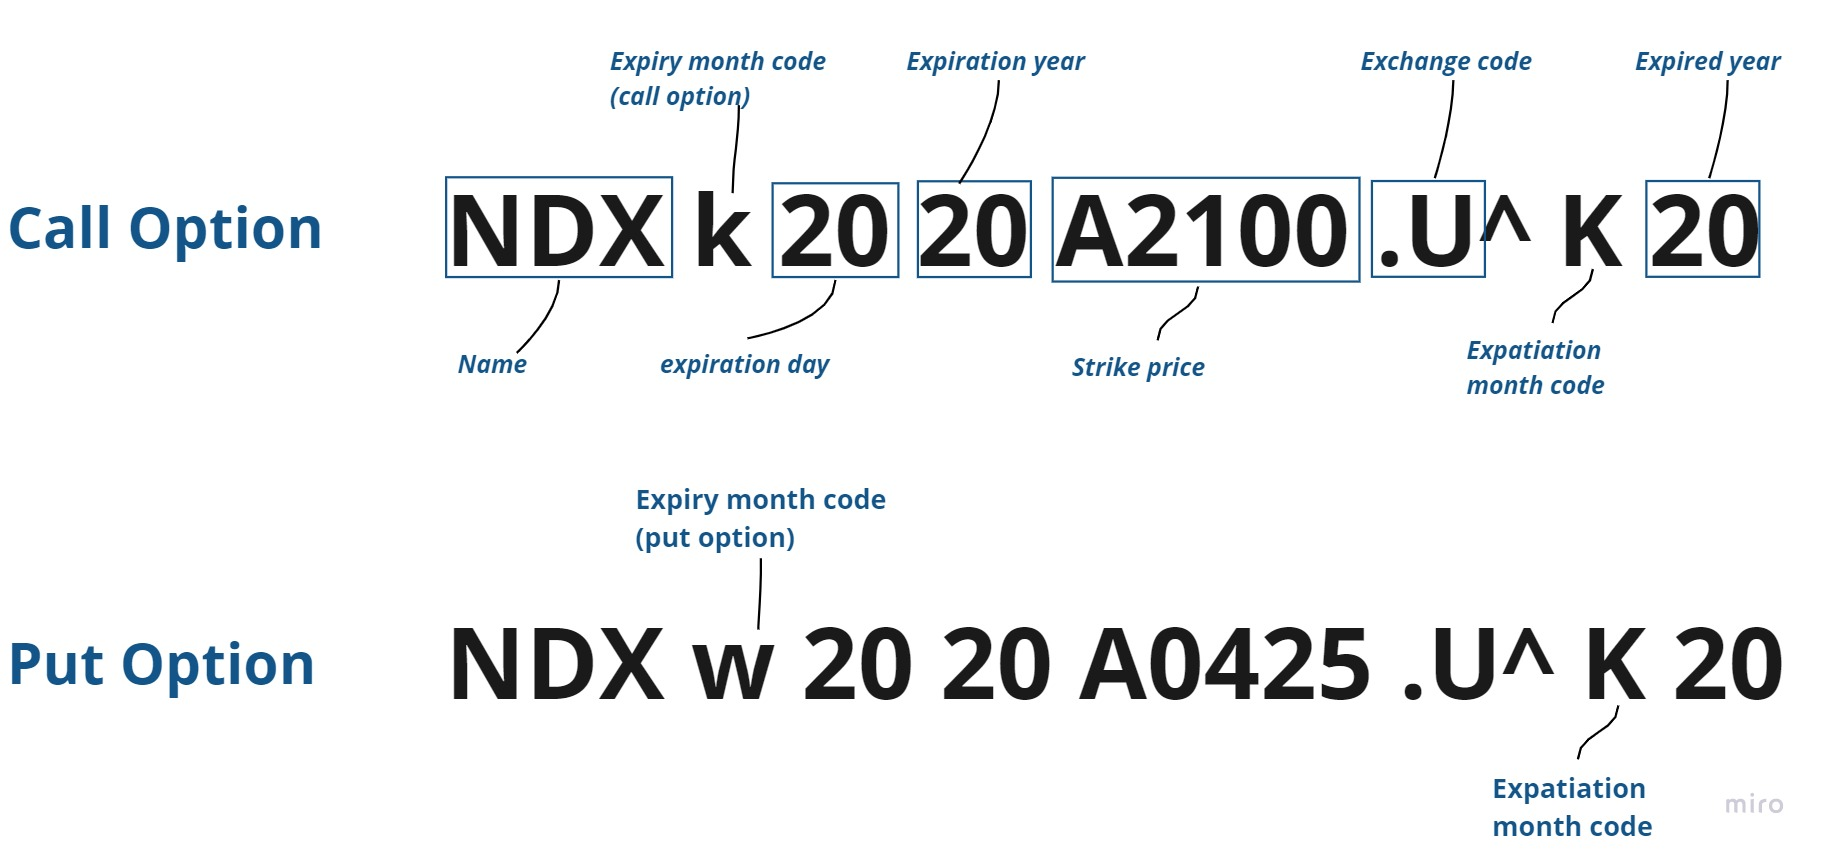

Below can be found the comprehensive list of Rules used to reconstruct expired option RICs examined in this article:

>**RULES7** | RIC rules to construct options on equities and indices (search in Workspace).

>**RULES2** | RIC Rules for Delivery Month Codes for Futures & Options(search in Workspace).

>**RULES3** and **RULES4** | RIC Rules for Exchange Identifiers(search in Workspace).

>**Guideline to pull expired options in Refinitiv Eikon** | can be accessed at [My Refinitiv](https://my.refinitiv.com/content/mytr/en/faqs/2018/09/000178972.html).

>**Guideline on RIC structure Enhancement for Strike Price 10000 and above** | can be accessed at [My Refinitiv](https://my.refinitiv.com/content/mytr/en/datanotification/DN099473.html).

>**Equity Options Product Specifications** | CBOE exchange rules to be accessed [here](https://www.cboe.com/exchange_traded_stock/equity_options_spec/).

>**SPX Options Product Specification** | CBOE exchange rules to be accessed [here](https://www.cboe.com/tradable_products/sp_500/spx_options/specifications/).

>**NDX options Product Specification** | NASDAQ FactSheet to be accessed [here](https://www.nasdaq.com/docs/2021/02/01/NDXFactSheet.pdf).

In order reconstruct RICs we need to get all the required components of RIC structure presented above. Most of the components are inputted directly to the function **get_potential_rics** introduced further in this article, whereas we have constructed separate functions to get Expiration days and Transaction days (we need this for the strike price component) as we will need to call those functions several times througout the process.

First we define a function to get expiration dates for each mont. Since AM settled monthly options settle on the 3rd Friday of each month we define a function which gets after having year as an input. It should be noted that the function considers also exchange holidays and if a day is a holiday the previuos day is considerd as suggested by exchange rules.

**For the current and for all of the following functions code explanations are made in code cell by using code comments**

In [18]:
def get_exp_dates(year):
    '''
    This functions gets expiration dates for a year for NDX options, which is the 3rd Friday of each month. 
    -----------------------------------------------
    Input:
        year(int): Year for which transaction days are requested
    Output:
        dates(dict): Dictionary of expiration days for each month of a specified year
    '''
    
    # get CBOE market holodays
    CBOE = mcal.get_calendar('CBOE_Index_Options')
    holidays = CBOE.holidays().holidays
    
    # set calendar starting from Saturday
    c = calendar.Calendar(firstweekday=calendar.SATURDAY)
    
    # get 3rd Friday for each month 
    exp_dates = {}
    for i in range(1, 13):        
        monthcal = c.monthdatescalendar(year, i)
        date = monthcal[2][-1]
        # check if found date is an holiday and get the previus date if it is
        if date in holidays:
            date = date + timedelta(-1)
        # append the date to the dictionary
        if year in exp_dates:
            exp_dates[year].append(date.day)
        else:
            exp_dates[year] = [date.day]        
    return exp_dates

Below we run the function to showcase the ouput for 2020

In [19]:
dates = get_exp_dates(2020)
dates

{2019: [18, 15, 15, 18, 17, 21, 19, 16, 20, 18, 15, 20]}

Next, we define function returning a transaction day for each of 12 months which is used for ***a. requesting underlying asset price based on which we calcuate strike price also considering the specified OTM size***, and ***b. conducting monthly option transaction***.

We provide two possible days for conducting option transaction which is controlled by the function parameter: 1. First business day of each month, 2. Exiration day of each month. We always buy/sell option contract expiring on the following month of purchase. For example, for January, 2021 we buy/sell option contract expiring on February 2021 either on the first business day, which is January 4, or expiration day, which is January 15.

In [24]:
def get_trans_days(year, trans_day = 'first'):
    '''
    This functions gets transaction days for each month of a specified year.
    --------------------------------
    Input:
        year (int): Year for which transaction days are requested
        trans_day (str, default = 'first'): takes either 'first' or 'exp' indicating first or expiration day of a month respectively
    Output:
        trans_days (list): list of days for 12 month
    '''
    # get first business day of each month
    if trans_day == 'first':
        CBOE = mcal.get_calendar('CBOE_Index_Options')
        holidays = CBOE.holidays().holidays
        
        # set start and end day ranges
        start_date = str(year) + '-01' +'-01'
        end_date = str(year) + '-12' + '-31'
        trans_days = []
        
        for date in pd.date_range(start_date, end_date, freq='BMS'):
            # get the first day after the weekend after checking for holiday
            while date.isoweekday() > 5 or date in holidays:
                date += dt.timedelta(1)
            # add found day to the list
            trans_days.append(date.date().day)
            
    # get expiration dat for each month by calling function "get_exp_dates"
    elif trans_day == 'exp':
        trans_days = get_exp_dates(year)[year]
    else:
        print('Please input "first" or "exp" for transaction day')
        return
    return trans_days

Below we run the function to showcase the ouput for 2020 with a parameter value of 'first'

In [25]:
trans_days = get_trans_days(2020, 'first')
trans_days

[2, 3, 2, 1, 1, 1, 1, 3, 1, 1, 2, 1]

As mentioned earlier, the most of the RIC components are contructed via a separate function mentioned below. This function calls the functions mentioned above and uses the input to construct other components of RIC. The function takes year, transaction day, asset name, OTM size, tolarated difference in OTM size and option type as an input and returns dictionary of potential RICs per month. For each month it produces several RICs which depend on the parameter of tolarated difference in OTM size. The reason we use tolarated difefrence in OTM is that it is mostly impossible to arrive at a valid strike price with any specified OTM.

The gernaral workflow on how the function works is illustrated in the image below: 

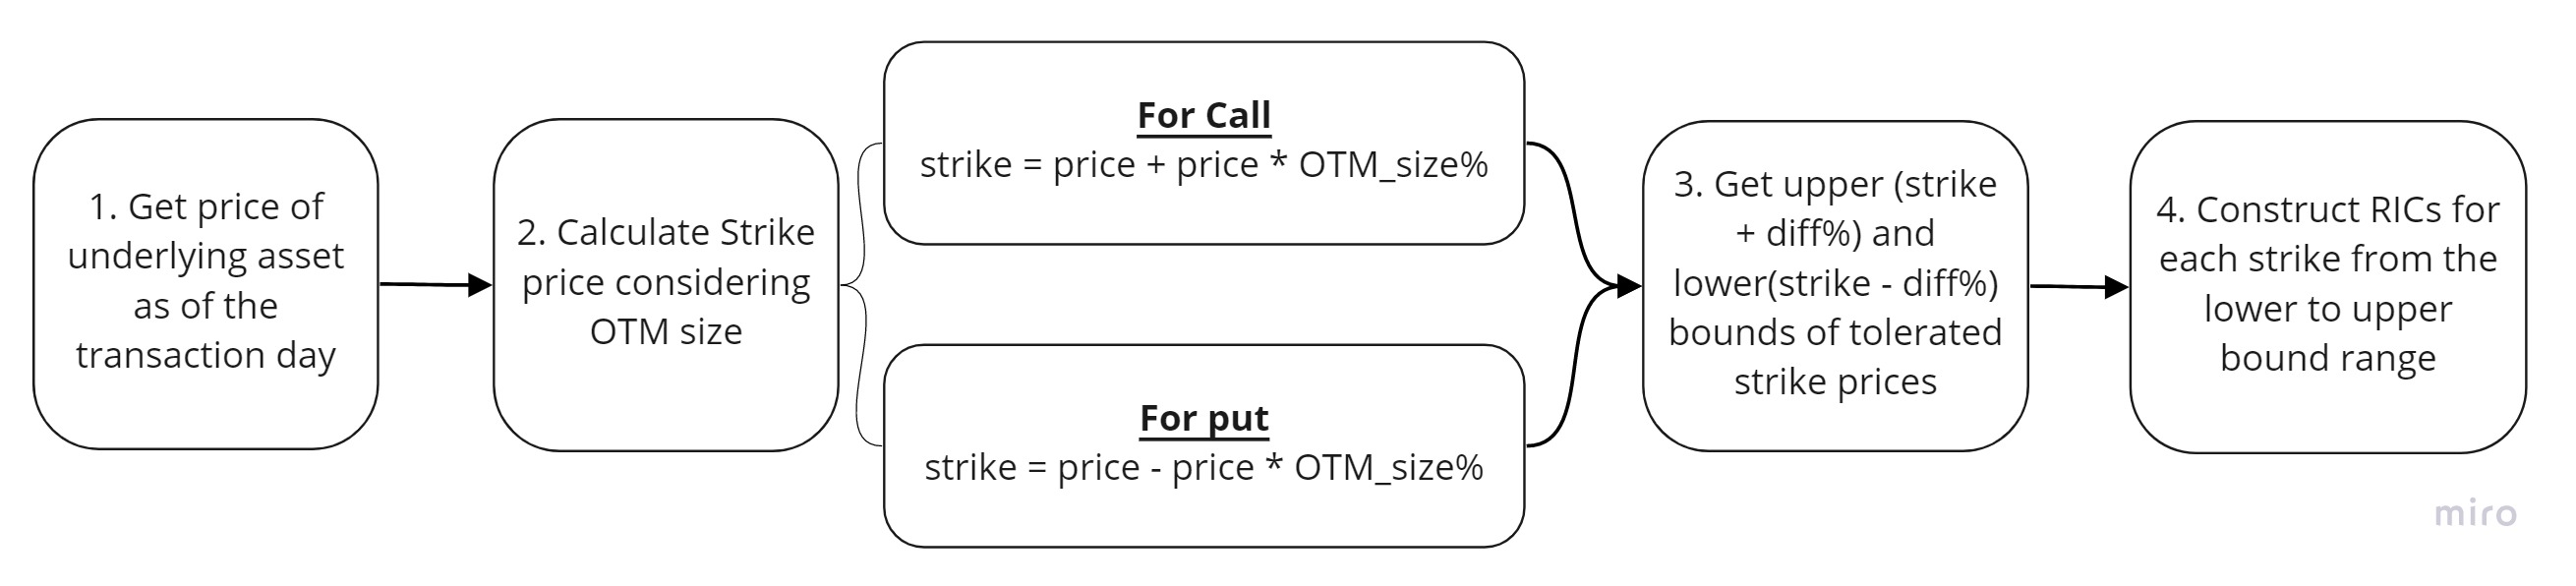

The function works for both indices and equities. The exact RIC codes (e.g ".NDX" or 'MSFT.O') for each asset needs to be given to the function. Further the function trims the necessary part of the asset RIC for option RIC construction. The rest of the details on constructing each component of option RIC is explained inside the code as comments.

After the code is fully executed we report the logs in a text file.

In [28]:
def get_potential_rics(year, trans_day, asset, OTM_size, diff, opt_type):
    '''
    This functions returns the list of potential option RICs for a specified year reconstructed based on Refinitiv RIC and option trading rules.
    --------------------------------------
    Input:
        year (int): Year for which transaction days are requested
        trans_day (str, default = 'first'): takes either 'first' or 'exp' indicating first or expiration day of a month respectively
        asset (str): RIC code of the asset
        OTM_size (int): percentage number indicating how far away is the strike price from the price of underlying asset
        diff (int): Tolarated difference in OTM to contruct upper and lower bound of strike prices
        opt_type (str): takes either "call" or "put"
    Output:
        potential_RICs (dict): dictionary containing potential RICs for each month with strike prices from the lower to upper bound of strikes
        strikes (list): list of strike prices calculayed based on OTM size for each month
    ''' 
    # open file to report log of function output
    report = open("Log report.txt", "a")
    
    # call functions to get expiration and transaction days
    trans_days = get_trans_days(year, trans_day)
    trans_days_prev = get_trans_days(year-1, trans_day)
    dates = get_exp_dates(year) 

    # trim underlying assets RIC to get the required part for option RIC
    if asset[0] == '.': #we remove "." symbol for index option
        asset_name = asset[1:]
    else:
        asset_name = asset.split('.')[0] #we need only first part of RICs for equities
        
    # define expiration month codes to be used after "^" sign
    exp = ['A', 'B', 'C', 'D','E','F','G', 'H', 'I', 'J', 'K', 'L']
    potential_RICs = {}
    strikes = []
    
    # construct potential RICs for each month of a specified year
    for j in range(1,13):
        # get day of expiration for a month
        day = dates[year][j-1]
        
        # get date of price request, which is in the previous month of expiration 
        if j != 1: 
            date = str(year) + '-' + str(j-1) + '-' + str(trans_days[j-2])
        if j == 1: #for January, we need to subtact year along with the month
            date = str(year-1) + '-' + str(j+11) + '-' + str(trans_days_prev[j+10])    
        # get price of underlying asset as of transaction date
        price, err = rdp.legacy.get_data(asset, fields = ['TR.PriceClose'], parameters = {'SDate': date})
        price = price.iloc[0,1]
        
        # calculate strike price for call options
        if opt_type == 'call':
            strike = price + price * OTM_size/100
            # define expiration month codes for call options while also considering the strike price
            if strike > 999.999:
                exp_codes_call = ['a', 'b', 'c', 'd','e','f','g', 'h', 'i', 'j', 'k', 'l']
            else:
                exp_codes_call = ['A', 'B', 'C', 'D','E','F','G', 'H', 'I', 'J', 'K', 'L']
            # get exp month code for a month
            exp_month = exp_codes_call[j-1]
            
        # calculate strike price and get exp month code for a month for pur options
        elif opt_type == 'put':
            strike = price - price * OTM_size/100
            if strike > 999.999:
                exp_codes_put = ['m', 'n', 'o', 'p','q','r','s', 't', 'u', 'v', 'w', 'x'] 
            else:
                exp_codes_put = ['M', 'N', 'O', 'P','Q','R','S', 'T', 'U', 'V', 'W', 'X']
            exp_month = exp_codes_put[j-1]
            
        strikes.append(int(round(strike,0))) # append calculated strike price to list of strikes
        
        # calculate lower and upper bound for strikes considering the value of strike
        if strike > 999.999:
            step = 5 # we loop over strikes with a step 5 for larger strikes
            strike_ub = int(round((strike + strike*diff/100),-1))
            strike_lb = int(round((strike - strike*diff/100),-1))
        else:
            step = 1 # we loop over strikes with a step 1 for smaler strikes
            strike_ub = int(strike + strike*diff/100)
            strike_lb = int(strike - strike*diff/100)
        
        # construct RICs for each strike from the lower to upper bound range of strikes
        for n in range(strike_lb, strike_ub + step, step):
            k = None # for strikes < 1000 along with 1 step increment changes in strikes we do 0.5 point increment changes which 
                     #allows to consider strikes with decimal points. This is important to get closer OTMs for smaller valued assets.
            # here we construct option RICs by adding together the all of the RIC components
            # Please note some of the components are different depending on the strike value
            if n < 10:
                z = asset_name + exp_month + str(day) + str(year)[-2:] + '00' + str(n) + '00.U^' + exp[j-1] + str(year)[-2:]# for integer steps
                k = asset_name + exp_month + str(day) + str(year)[-2:] + '00' + str(n) + '50.U^' + exp[j-1] + str(year)[-2:]# for decimal steps
            elif n >= 10 and n < 100:
                z = asset_name + exp_month + str(day) + str(year)[-2:] + '0' + str(n) + '00.U^' + exp[j-1] + str(year)[-2:]
                k = asset_name + exp_month + str(day) + str(year)[-2:] + '0' + str(n) + '50.U^' + exp[j-1] + str(year)[-2:]
            if n >= 100 and n < 1000:
                z = asset_name + exp_month + str(day) + str(year)[-2:] + str(n) + '00.U^' + exp[j-1] + str(year)[-2:]   
                k = asset_name + exp_month + str(day) + str(year)[-2:] + str(n) + '50.U^' + exp[j-1] + str(year)[-2:]
            elif n >= 1000 and n < 10000:
                z = asset_name + exp_month + str(day) + str(year)[-2:] + str(n) + '0.U^' + exp[j-1] + str(year)[-2:]
            elif n >= 10000 and n < 20000:
                z = asset_name + exp_month + str(day) + str(year)[-2:] + 'A' + str(n)[-4:] + '.U^' + exp[j-1] + str(year)[-2:]
            elif n >= 20000 and n < 30000:
                z = asset_name + exp_month + str(day) + str(year)[-2:] + 'B' + str(n)[-4:] + '.U^' + exp[j-1] + str(year)[-2:]
            elif n >= 30000 and n < 40000:
                z = asset_name + exp_month + str(day) + str(year)[-2:] + 'C' + str(n)[-4:] + '.U^' + exp[j-1] + str(year)[-2:]
            elif n >= 40000 and n < 50000:
                z = asset_name + exp_month + str(day) + str(year)[-2:] + 'D' + str(n)[-4:] + '.U^' + exp[j-1] + str(year)[-2:]
            
            # append RICs with integer strikes to the dictionary
            if j in potential_RICs:
                potential_RICs[j].append(z)
                # append RICs with decimal point strikes to the dictionary
                if k is not None:
                    potential_RICs[j].append(k)
            else:
                potential_RICs[j] = [z]
                if k is not None:
                    potential_RICs[j].append(k)  
                    
    # report funtion results and close log file
    now = {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
    report.write(f'{now}: Potential RICs for {opt_type} options with {OTM_size}% OTM for {year} are constructed\n')
    report.close()
    return potential_RICs, strikes

Below we run the function to showcase the ouput for call option from 2020 with 10% OTM and 0.5% tolerance.

In [29]:
call_RICs, call_strikes = get_potential_rics(2020, 'first','.NDX', 10, 0.5, 'call')
print(call_RICs)

{1: ['NDXa172090900.U^A20', 'NDXa172090950.U^A20', 'NDXa172091000.U^A20', 'NDXa172091050.U^A20', 'NDXa172091100.U^A20', 'NDXa172091150.U^A20', 'NDXa172091200.U^A20', 'NDXa172091250.U^A20', 'NDXa172091300.U^A20', 'NDXa172091350.U^A20', 'NDXa172091400.U^A20', 'NDXa172091450.U^A20', 'NDXa172091500.U^A20', 'NDXa172091550.U^A20', 'NDXa172091600.U^A20', 'NDXa172091650.U^A20', 'NDXa172091700.U^A20', 'NDXa172091750.U^A20', 'NDXa172091800.U^A20', 'NDXa172091850.U^A20', 'NDXa172091900.U^A20'], 2: ['NDXb212097100.U^B20', 'NDXb212097150.U^B20', 'NDXb212097200.U^B20', 'NDXb212097250.U^B20', 'NDXb212097300.U^B20', 'NDXb212097350.U^B20', 'NDXb212097400.U^B20', 'NDXb212097450.U^B20', 'NDXb212097500.U^B20', 'NDXb212097550.U^B20', 'NDXb212097600.U^B20', 'NDXb212097650.U^B20', 'NDXb212097700.U^B20', 'NDXb212097750.U^B20', 'NDXb212097800.U^B20', 'NDXb212097850.U^B20', 'NDXb212097900.U^B20', 'NDXb212097950.U^B20', 'NDXb212098000.U^B20', 'NDXb212098050.U^B20', 'NDXb212098100.U^B20'], 3: ['NDXc202099900.U^C2

The output from the function get_potential_rics lists the RICs for each month with strike prices from the range lower to upper bound of strikes. In order to make sure we are trading the option with a strike price closest to the specified OTM price we need to sort the RICs of each month in an order of closeseness of option contract strike price with OTM price. The function below takes potential RICs and strike prices (OTM calculated) as an input and returns the sorted dictionary of RICs. 

In [30]:
def sort_option(pot_RICs, strikes):
    '''
    This functions sorts the potential RICs in an order of closeseness of option contract strike price with underlying price with given OTM.
    --------------------------------------
    Input:
        pot_RICs (dict): dictionary containing potential RICs for each month with strike prices from the lower to upper bound of strikes
        strikes (list): list of strike prices calculayed based on OTM size for each month 
    Output:
        pot_RICs (dict): dictionary containing potential RICs for each month sortedin an order of closeseness of option contract strike price with underlying price with given OTM
    '''
    i = -1
    # loop over each month
    for month in pot_RICs:
        i += 1
        # loop over each RIC per month
        for RIC in pot_RICs[month]:
            # calculate the absolute difference of option strike price and the strike price calculated based on specified OTM size
            sort = [abs(int(RIC[-11:-7]) - int((str(strikes[i])[-4:]+ '0')[:4])) if RIC[-11] != 'A' else 
                    abs(int(RIC[-10:-6]) - int(str(strikes[i])[-4:])) for RIC in pot_RICs[month]]
            # sort original dictionary with the sort order
            pot_RICs[month] = [month_sorted for _, month_sorted in sorted(zip(sort, pot_RICs[month]))]
    return pot_RICs

Below we run the function to showcase the sorted output.

In [31]:
call_sorted = sort_option(call_RICs,  call_strikes)
print(call_sorted)

{1: ['NDXa172091400.U^A20', 'NDXa172091350.U^A20', 'NDXa172091450.U^A20', 'NDXa172091300.U^A20', 'NDXa172091500.U^A20', 'NDXa172091250.U^A20', 'NDXa172091550.U^A20', 'NDXa172091200.U^A20', 'NDXa172091600.U^A20', 'NDXa172091150.U^A20', 'NDXa172091650.U^A20', 'NDXa172091100.U^A20', 'NDXa172091700.U^A20', 'NDXa172091050.U^A20', 'NDXa172091750.U^A20', 'NDXa172091000.U^A20', 'NDXa172091800.U^A20', 'NDXa172090950.U^A20', 'NDXa172091850.U^A20', 'NDXa172090900.U^A20', 'NDXa172091900.U^A20'], 2: ['NDXb212097600.U^B20', 'NDXb212097550.U^B20', 'NDXb212097650.U^B20', 'NDXb212097500.U^B20', 'NDXb212097700.U^B20', 'NDXb212097450.U^B20', 'NDXb212097750.U^B20', 'NDXb212097400.U^B20', 'NDXb212097800.U^B20', 'NDXb212097350.U^B20', 'NDXb212097850.U^B20', 'NDXb212097300.U^B20', 'NDXb212097900.U^B20', 'NDXb212097250.U^B20', 'NDXb212097950.U^B20', 'NDXb212097200.U^B20', 'NDXb212098000.U^B20', 'NDXb212097150.U^B20', 'NDXb212098050.U^B20', 'NDXb212097100.U^B20', 'NDXb212098100.U^B20'], 3: ['NDXc2020A0040.U^C2

As the name of the get_potential_rics function indicates, it produces list of potential RICs part of which (sometimes all, if you request for higher OTMs for illiquid option contract) is not an actual RIC. In order to validate them, we need to make API calls. Here we use **get_historical_price_summaries** from RDP API which results None if the RIC is invalid, otherwise it returns the values from the specified fields. One may you **get_date** from Eikon API, however it returns error if the RIC is invalid and you may need to write try/except loop and hide the errors/warnings. 

It should be noted that the function mentioned below should be **used only** if one wants to **validate all RICs** from the list of potential RICs. As a rule, in option strategy backtestings when you found a valid RIC for a month, you don't have to test other RICs of that month as you have already traded one. In our example, to test short iron condor strategy, we don't call this function, instead we chack the validity of a RIC right inside the transaction function (see function **trans_option**) to avoid extensive API requests and hitting the daily limit of 10000 requests.

In [32]:
def get_valid_rics(year, trans_day, pot_RICs_sorted):
    '''
    This functions checks the validity of a RIC by making API calls and returns dictionary of valid RICs per month at a specified year. 
    --------------------------------------
    Input:
        year (int): Year for which transaction days are requested
        trans_day (str, default = 'first'): takes either 'first' or 'exp' indicating first or expiration day of a month respectively
        pot_RICs_sorted (dict): dictionary containing potential RICs which are already sorted
    Output:
        valid_rics (dict): dictionary containing validated RICs for each month
    '''
    report = open("Log report.txt", "a")
    
    trans_days = get_trans_days(year, trans_day)
    dates = get_exp_dates(year)
    trans_days_prev = get_trans_days(year-1, trans_day)
    valid_rics = {}
    
    # get start and end date of the api requests
    for month in pot_RICs_sorted:
        edate = str(year) + '-' + str(month) + '-' + str(dates[year][month-1])
        if month > 1:
            sdate = str(year) + '-' + str(month-1) + '-' + str(trans_days[month-2])
        if month == 1:
            sdate = str(year-1) + '-' + str(month+11) + '-' + str(trans_days_prev[month+10])
        
        # make an API call for each RIC for each month
        for RIC in pot_RICs_sorted[month]:
            vals = rdp.get_historical_price_summaries(RIC,  start = sdate, end = edate, interval = rdp.Intervals.DAILY,
                                                        fields = ['BID','ASK','TRDPRC_1'])  
            # add valid RICs to a dictionary
            if vals is not None:
                vals.reset_index(inplace = True)
                if month in valid_rics:
                    valid_rics[month].append(RIC)
                else:
                    valid_rics[month] = [RIC]
                    
    now = {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
    report.write(f'{now}: Valid RICs with specified criteria for {len(valid_rics)} month during {year} are found\n')
    report.close()
    return valid_rics

Below we run the function to showcase the valid RICs.

In [33]:
valid_rics_call = get_valid_rics(2020,'first', call_sorted)
print(valid_rics_call)

{1: ['NDXa172091400.U^A20', 'NDXa172091300.U^A20', 'NDXa172091500.U^A20', 'NDXa172091250.U^A20', 'NDXa172091200.U^A20', 'NDXa172091600.U^A20', 'NDXa172091100.U^A20', 'NDXa172091700.U^A20', 'NDXa172091750.U^A20', 'NDXa172091000.U^A20', 'NDXa172091800.U^A20', 'NDXa172090900.U^A20', 'NDXa172091900.U^A20'], 2: ['NDXb212097600.U^B20', 'NDXb212097500.U^B20', 'NDXb212097700.U^B20', 'NDXb212097750.U^B20', 'NDXb212097400.U^B20', 'NDXb212097800.U^B20', 'NDXb212097300.U^B20', 'NDXb212097900.U^B20', 'NDXb212097250.U^B20', 'NDXb212097200.U^B20', 'NDXb212098000.U^B20', 'NDXb212097100.U^B20', 'NDXb212098100.U^B20'], 3: ['NDXc2020A0040.U^C20', 'NDXc2020A0030.U^C20', 'NDXc2020A0050.U^C20', 'NDXc2020A0025.U^C20', 'NDXc2020A0020.U^C20', 'NDXc2020A0060.U^C20', 'NDXc2020A0010.U^C20', 'NDXc2020A0070.U^C20', 'NDXc2020A0075.U^C20', 'NDXc2020A0000.U^C20', 'NDXc2020A0080.U^C20', 'NDXc2020A0090.U^C20', 'NDXc202099900.U^C20'], 4: ['NDXd172097750.U^D20', 'NDXd172097500.U^D20', 'NDXd172098000.U^D20', 'NDXd172097250

## Section 2: Option transactions and strategy outcome

1. Long/short option contracts on the first business day or the expiratof every month

2. Options expire in the following month of the purchase

3. We aim to buy/sell contracts with a strike price closest to the specified OTM size

4. Option contract price is considered to be one of the following (in an order as provided below):
   
>a. Trade price
   
>b. BID/ASK mid price
   
>c. ASK price minus average bid/ask spread for the period
   
>d. BID price plus average bid/ask spread for the period
   
>e. ASK price
   
>f. BID price

### 2.1.Function to register Option buy/sell transactions

In [10]:
def trans_option(year, trans_day, asset, RICs, opt_type, position):
    '''
    This functions registers the option contract buy/sell transaction for each month in a given year along with other transaction details,
    such as Strike price, underlying price, actual OTM size etc.  
    '''         
    report = open("Log report.txt", "a")
    trans_days = get_trans_days(year, trans_day)
    dates = get_exp_dates(year)
    trans_days_prev = get_trans_days(year-1, trans_day)
    
    dict = {'RIC':[],'Trans_Date':[],'Exp_date': [],'Option type':[], 'Position':[], 'Strike':[], 'Price_Trans_Date': [], 'Option Price':[], 'OTM size': []}
    
    for month in RICs:
        for RIC in RICs[month]:
            edate = str(year) + '-' + str(month) + '-' + str(dates[year][month-1])
            if month > 2:
                sdate = str(year) + '-' + str(month-1) + '-' + str(trans_days[month-2])
                sdate_req = str(year) + '-' + str(month-2) + '-' + str(trans_days[month-3])
            if month == 1:
                sdate = str(year-1) + '-' + str(month+11) + '-' + str(trans_days_prev[month+10])
                sdate_req = str(year-1) + '-' + str(month+10) + '-' + str(trans_days_prev[month-4])
            if month == 2:
                sdate = str(year) + '-' + str(month-1) + '-' + str(trans_days[month-2])
                sdate_req = str(year-1) + '-' + str(month+10) + '-' + str(trans_days_prev[month-4])
                
            vals = rdp.get_historical_price_summaries(RIC,  start = sdate_req, end = edate, interval = rdp.Intervals.DAILY,
                                                        fields = ['BID','ASK','TRDPRC_1'])         
            if vals is not None:
                vals.reset_index(inplace = True)
                if vals.loc[vals['index'] == sdate].shape[0] == 1:
                    if len(vals['TRDPRC_1'].loc[vals['index'] == sdate]) == 1 and vals['TRDPRC_1'].loc[vals['index'] == sdate].notna().any():
                        price = vals['TRDPRC_1'].loc[vals['index'] == sdate].values[0]
                    elif (vals['ASK']).sum() == 0 and (vals['BID']).sum() != 0:
                        price = vals['BID'].loc[vals['index'] == sdate].values[0]  
                    elif (vals['ASK']).sum() != 0 and (vals['BID']).sum() == 0:
                        price = vals['ASK'].loc[vals['index'] == sdate].values[0]
                    elif vals['ASK'].loc[vals['index'] == sdate].any() == True and vals['BID'].loc[vals['index'] == sdate].any() == True:
                        price = (vals['ASK'].loc[vals['index'] == sdate].values[0] + vals['BID'].loc[vals['index'] == sdate].values[0])/2
                    elif vals['ASK'].loc[vals['index'] == sdate].any() == True and vals['BID'].loc[vals['index'] == sdate].any() == False:
                        av_spread = ((vals['ASK'] - vals['BID'])/vals['ASK']).mean()
                        price = vals['ASK'].loc[vals['index'] == sdate].values[0] - vals['ASK'].loc[vals['index'] == sdate].values[0]*av_spread
                    elif vals['ASK'].loc[vals['index'] == sdate].any() == False and vals['BID'].loc[vals['index'] == sdate].any() == True:
                        av_spread = ((vals['ASK'] - vals['BID'])/vals['BID']).mean()
                        price = vals['BID'].loc[vals['index'] == sdate].values[0] + vals['BID'].loc[vals['index'] == sdate].values[0]*av_spread  

                    dict['Option Price'].append(round(float(price),2))
                    dict['Trans_Date'].append(vals['index'].loc[vals['index'] == sdate].values[0])
                    dict['Option type'].append(opt_type)
                    dict['Exp_date'].append(datetime.strptime(edate, '%Y-%m-%d'))
                    dict['RIC'].append(RIC)              
                    dict['Position'].append(position)
                    
                    prices = []                    
                    val, err = rdp.legacy.get_data(asset, fields = ['TR.PriceClose'], parameters = {'SDate': sdate})
                    price = val.iloc[0,1]
                    
                    if price < 10:
                        int_part = int(RIC[-9:-8])
                        dec_part = RIC[-8:-6]
                        strike = float(int_part + '.' + dec_part)
                    elif price >= 10 and price < 100:
                        int_part = RIC[-10:-8]
                        dec_part = RIC[-8:-6]
                        strike = float(int_part + '.' + dec_part)
                    elif price >= 100 and price < 1000:
                        int_part = RIC[-10:-8]
                        dec_part = RIC[-8:-6]
                        strike = float(int_part + '.' + dec_part)
                    elif price >= 1000 and price < 10000:
                        if RIC[-11] == 'A':
                            strike = float(RIC[-11:-6].replace('A', "1"))
                        else:
                            strike = float(RIC[-11:-7])
                    elif price >= 10000 and price < 20000:
                        if RIC[-11] == 'A':
                            strike = float(RIC[-11:-6].replace('A', "1"))
                        else:
                            strike = float(RIC[-11:-7])
                    elif price >= 20000 and price < 30000:
                        strike = float(RIC[-11:-6].replace('B', "2"))
                    elif price >= 30000 and price < 40000:
                        strike = float(RIC[-11:-6].replace('C', "3"))
                    elif price >= 40000 and price < 50000:
                        strike = float(RIC[-11:-6].replace('D', "4"))
                    dict['Strike'].append(strike)
                    
                    if opt_type == 'call':
                        OTM = round((strike - price)/price*100, 2)
                    elif opt_type == 'put':
                        OTM = round((price - strike)/price*100, 2)  
                    dict['OTM size'].append(OTM)
                    dict['Price_Trans_Date'].append(price)
                    break
    
        if datetime.strptime(edate, '%Y-%m-%d') not in dict['Exp_date']:
            now = {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
            report.write(f'{now}: No {opt_type} option is purchased for month {month}\n')
            
    now = {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
    report.write(f'{now}: {len(pd.DataFrame(dict))} {position} {opt_type} transactions for {year} are registered\n')
    report.close()
    return pd.DataFrame(dict)

In [ ]:
call_trans = trans_option(2020,'first', '.NDX', call_sorted, 'call', 'short')

In [11]:
def pair_trans(year, trans_day, asset, call_OTM, put_OTM, call_pos, put_pos):
    '''
    This functions implements option pair transaction by calling some of the abovementioned functions for call/put pair.
    '''    
    call_RICs, call_strikes = get_potential_rics(year, trans_day, asset, call_OTM, 2, 'call')
    call_sorted = sort_option(call_RICs, call_strikes)
    call_trans = trans_option(year, trans_day, asset, call_sorted, 'call', call_pos)
    
    put_RICs, put_strikes = get_potential_rics(year, trans_day, asset, put_OTM, 2, 'put')
    put_sorted = sort_option(put_RICs, put_strikes)
    put_trans = trans_option(year, trans_day, asset, put_sorted, 'put', put_pos)
    
    return call_trans, put_trans

In [ ]:
call_trans, put_trans = pair_trans(2020, 'first', '.NDX', 10, 10, 'long', 'long')

In [13]:
call_trans

,RIC,Trans_Date,Exp_date,Option type,Position,Strike,Price_Trans_Date,Option Price,OTM size
0,NDXa172099000.U^A20,2019-12-02,2020-01-17,call,short,9900.0,8309.260,0.04,19.14
1,NDXd1720A0700.U^D20,2020-03-02,2020-04-17,call,short,10700.0,8877.978,1.52,20.52
2,NDXe152090000.U^E20,2020-04-01,2020-05-15,call,short,9000.0,7486.287,22.00,20.22
3,NDXf1920A0450.U^F20,2020-05-01,2020-06-19,call,short,10450.0,8718.179,4.50,19.86
4,NDXg1720A1500.U^G20,2020-06-01,2020-07-17,call,short,11500.0,9598.887,4.47,19.81
5,NDXi1820A3000.U^I20,2020-08-03,2020-09-18,call,short,13000.0,11055.076,4.30,17.59
6,NDXk2020A3900.U^K20,2020-10-01,2020-11-20,call,short,13900.0,11583.203,17.80,20.00
7,NDXl1820A3300.U^L20,2020-11-02,2020-12-18,call,short,13300.0,11084.757,13.02,19.98


In [14]:
put_trans

,RIC,Trans_Date,Exp_date,Option type,Position,Strike,Price_Trans_Date,Option Price,OTM size
0,NDXm172074750.U^A20,2019-12-02,2020-01-17,put,long,7475.0,8309.260,31.65,10.04
1,NDXn212080000.U^B20,2020-01-02,2020-02-21,put,long,8000.0,8872.219,31.36,9.83
2,NDXo202082250.U^C20,2020-02-03,2020-03-20,put,long,8225.0,9126.232,55.30,9.88
3,NDXp172080000.U^D20,2020-03-02,2020-04-17,put,long,8000.0,8877.978,170.52,9.89
4,NDXq152067500.U^E20,2020-04-01,2020-05-15,put,long,6750.0,7486.287,280.75,9.84
5,NDXr192078500.U^F20,2020-05-01,2020-06-19,put,long,7850.0,8718.179,182.35,9.96
6,NDXs172086500.U^G20,2020-06-01,2020-07-17,put,long,8650.0,9598.887,111.75,9.89
7,NDXt212092500.U^H20,2020-07-01,2020-08-21,put,long,9250.0,10279.248,143.20,10.01
8,NDXu182099500.U^I20,2020-08-03,2020-09-18,put,long,9950.0,11055.076,131.55,10.00
9,NDXv1620A1075.U^J20,2020-09-01,2020-10-16,put,long,11075.0,12292.863,191.00,9.91


### 2.2 Function to offset transaction - Trigger VIX

>1. We offset open transactions by taking the opposite position of our original contracts

>2. The trigger to offset is when 3 day moving average of VIX exceeds the threshold

>3. Threshold is the 2 standart deviation of previous period's VIX price change

>4. Moving average helps to make movements smoother to avoid from false alarms

>5. Stdev of VIX change allows to have more flexible threshold which considers past market condition, instead of the fixed one

In [15]:
trans = pd.concat([call_trans, put_trans]).reset_index()
trans.drop(columns = ['index'], inplace=True)
trans = trans.sort_values(by = ['Trans_Date'])
trans

,RIC,Trans_Date,Exp_date,Option type,Position,Strike,Price_Trans_Date,Option Price,OTM size
0,NDXa172099000.U^A20,2019-12-02,2020-01-17,call,short,9900.0,8309.260,0.04,19.14
8,NDXm172074750.U^A20,2019-12-02,2020-01-17,put,long,7475.0,8309.260,31.65,10.04
9,NDXn212080000.U^B20,2020-01-02,2020-02-21,put,long,8000.0,8872.219,31.36,9.83
10,NDXo202082250.U^C20,2020-02-03,2020-03-20,put,long,8225.0,9126.232,55.30,9.88
11,NDXp172080000.U^D20,2020-03-02,2020-04-17,put,long,8000.0,8877.978,170.52,9.89
1,NDXd1720A0700.U^D20,2020-03-02,2020-04-17,call,short,10700.0,8877.978,1.52,20.52
12,NDXq152067500.U^E20,2020-04-01,2020-05-15,put,long,6750.0,7486.287,280.75,9.84
2,NDXe152090000.U^E20,2020-04-01,2020-05-15,call,short,9000.0,7486.287,22.00,20.22
13,NDXr192078500.U^F20,2020-05-01,2020-06-19,put,long,7850.0,8718.179,182.35,9.96
3,NDXf1920A0450.U^F20,2020-05-01,2020-06-19,call,short,10450.0,8718.179,4.50,19.86


In [20]:
def exit_trans(option_trans):
    report = open("Log report.txt", "a")
    exit_dict = {'RIC':[],'Trans_Date':[],'Exp_date': [],'Option type':[], 'Position':[], 'Strike':[], 'Price_Trans_Date': [], 'Option Price':[], 'OTM size': []}
    
    for date in option_trans['Trans_Date'].unique():
        
        sdate = pd.to_datetime(str(date - np.timedelta64(1,'D'))).strftime('%Y-%m-%d')
        sdate_req = pd.to_datetime(str(date - np.timedelta64(30,'D'))).strftime('%Y-%m-%d')
        date = pd.to_datetime(str(date)).strftime('%Y-%m-%d')
        index = option_trans.loc[option_trans['Trans_Date'] == date].index
        edate = pd.to_datetime(str(option_trans['Exp_date'][index[0]])).strftime('%Y-%m-%d')
        edate_1 = pd.to_datetime(str(option_trans['Exp_date'][index[0]]- np.timedelta64(1,'D'))).strftime('%Y-%m-%d')

        vix = rdp.get_historical_price_summaries('.VIX',  start = sdate_req, end = edate_1,
                                                 fields = ['TRDPRC_1'], interval = rdp.Intervals.DAILY).astype(float)
        vix["VIX_change"] = vix['TRDPRC_1'].pct_change()*100
        vix.reset_index(inplace = True)
        vix_pr = vix['TRDPRC_1'].to_numpy()
        vix['ma'] = moving_average(vix_pr, 3)
        vix["ma_change"] = vix['ma'].pct_change()*100
        vix['diff'] = vix['ma'].diff()
        
        thresh = vix['VIX_change'].loc[vix['index'] < date].std() * 2
        for day in vix.loc[vix['index'] > date]['index']:
            if vix['ma_change'].loc[vix['index'] == day].values > thresh:
                vix_date = vix['index'].loc[vix['index'] == day].values
                sdate = pd.to_datetime(str(vix_date[0] - np.timedelta64(30,'D'))).strftime('%Y-%m-%d')
                edate = pd.to_datetime(str(vix_date[0] + np.timedelta64(1,'D'))).strftime('%Y-%m-%d')
                
                for idx in index:
                    RIC = option_trans['RIC'][idx]
                    prices = rdp.get_historical_price_summaries(RIC,  start = str(sdate), end = str(edate), interval = rdp.Intervals.DAILY,
                                                                    fields = ['BID','ASK','TRDPRC_1']).reset_index()

                    if len(prices['TRDPRC_1'].loc[prices['index'] == vix_date[0]]) == 1 and prices['TRDPRC_1'].loc[prices['index'] == vix_date[0]].notna().any():
                        price = prices['TRDPRC_1'].loc[prices['index'] == vix_date[0]].values[0]
                    elif (prices['ASK']).sum() == 0 and (prices['BID']).sum() != 0:
                        price = prices['BID'].loc[prices['index'] == vix_date[0]].values[0]
                    elif (prices['ASK']).sum() != 0 and (prices['BID']).sum() == 0:
                        price = prices['ASK'].loc[prices['index'] == vix_date[0]].values[0]
                    elif prices['ASK'].loc[prices['index'] == vix_date[0]].any() == True and prices['BID'].loc[prices['index'] == vix_date[0]].any() == True:
                        price = (prices['ASK'].loc[prices['index'] == vix_date[0]].values[0] + prices['BID'].loc[prices['index'] == vix_date[0]].values[0])/2
                    elif prices['ASK'].loc[prices['index'] == vix_date[0]].any() == True and prices['BID'].loc[prices['index'] == vix_date[0]].any() == False:
                        av_spread = ((prices['ASK'] - prices['BID'])/prices['ASK']).mean()
                        price = prices['ASK'].loc[prices['index'] == vix_date[0]].values[0] - prices['ASK'].loc[prices['index'] == vix_date[0]].values[0]*av_spread
                    elif prices['ASK'].loc[prices['index'] == vix_date[0]].any() == False and prices['BID'].loc[prices['index'] == vix_date[0]].any() == True:
                        av_spread = ((prices['ASK'] - prices['BID'])/prices['BID']).mean()
                        price = prices['BID'].loc[prices['index'] == vix_date[0]].values[0] + prices['BID'].loc[prices['index'] == vix_date[0]].values[0]*av_spread  
                    else:
                        break
                    
                    exit_dict['RIC'].append(RIC)
                    exit_dict['Trans_Date'].append(vix_date[0])
                    exit_dict['Exp_date'].append(option_trans['Exp_date'][idx])
                    exit_dict['Option type'].append(option_trans['Option type'][idx])
                    if option_trans['Position'][idx] == 'short':
                        exit_dict['Position'].append('long')
                    else:
                        exit_dict['Position'].append('short')
                    exit_dict['Strike'].append(option_trans['Strike'][idx])
                    exit_dict['Price_Trans_Date'].append(np.nan)
                    exit_dict['Option Price'].append((round(float(price),2))) 
                    exit_dict['OTM size'].append(np.nan)

                now = {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
                report.write(f'{now}: Positions for option pair opened on {date} has been exited through offset transaction\n')
                break
    report.close()
    return pd.DataFrame(exit_dict)

In [21]:
def moving_average(stock_price, n = 3):

    i = len(stock_price)
    if len(stock_price) < n:
        print("Moving average period can not be greater then number of days the stock is traded")
    else:
        ma_l = []
        for i in range(len(stock_price), n - 1, -1):
            point = stock_price[(i - n) : i]
            point_average = np.sum(point) / n
            ma_l.append(point_average)

        for i in range(n - 1, 0, - 1):
            point = stock_price[0 : i]
            point_average = np.sum(point) / i
            ma_l.append(point_average)
        ma_l.reverse()
        ma = np.array(ma_l)
        
        return ma

In [18]:
exit_trans = exit_trans(trans)
exit_trans

,RIC,Trans_Date,Exp_date,Option type,Position,Strike,Price_Trans_Date,Option Price,OTM size
0,NDXa172099000.U^A20,2019-12-03,2020-01-17,call,long,9900.0,NaN,0.04,NaN
1,NDXm172074750.U^A20,2019-12-03,2020-01-17,put,short,7475.0,NaN,48.35,NaN
2,NDXn212080000.U^B20,2020-01-27,2020-02-21,put,short,8000.0,NaN,19.90,NaN
3,NDXo202082250.U^C20,2020-02-24,2020-03-20,put,short,8225.0,NaN,62.70,NaN
4,NDXr192078500.U^F20,2020-06-11,2020-06-19,put,short,7850.0,NaN,5.10,NaN
5,NDXf1920A0450.U^F20,2020-06-11,2020-06-19,call,long,10450.0,NaN,17.30,NaN
6,NDXg1720A1500.U^G20,2020-06-11,2020-07-17,call,long,11500.0,NaN,5.80,NaN
7,NDXs172086500.U^G20,2020-06-11,2020-07-17,put,short,8650.0,NaN,98.20,NaN


### 2.3 Function to calculate and report Outcome of a strategy

In [22]:
def strategy_outcome(call_trans, put_trans, asset, cons_vix):
    '''
    This functions summarizes the strategy outcome by calculating profit/loss of each trnsaction and the bundle.
    ''' 
    report = open("Log report.txt", "a")
    option_trans = pd.concat([call_trans, put_trans]).reset_index()
    option_trans.drop(columns = ['index'], inplace=True)
    
    for date in option_trans['Exp_date']:
        if option_trans[option_trans['Exp_date'] == date].shape[0] < 2:
            option_trans.drop(option_trans.loc[option_trans['Exp_date'] == date].index, inplace=True)
            now = {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
            report.write(f'{now}: Transations with {date} expiration date has been removed because of unavailble option pair\n')
    option_trans = option_trans.sort_values(by=['Exp_date'])
    
    if cons_vix == 'yes':        
        offset_trans = exit_trans(option_trans)
        option_trans = pd.concat([option_trans, offset_trans]).sort_values(by=['Exp_date'])

    option_trans.index = option_trans.index + 1

    close_date = []
    prices_cdate = []
    for RIC in option_trans['RIC']:
        if option_trans.loc[option_trans['RIC'] == RIC].shape[0] == 1:
            close_date.append(option_trans['Exp_date'].loc[option_trans['RIC'] == RIC].values[0])
        elif option_trans.loc[option_trans['RIC'] == RIC].shape[0] == 2:
            close_date.append(np.max(option_trans['Trans_Date'].loc[option_trans['RIC'] == RIC].values))
            
    option_trans.insert(loc = len(option_trans.columns), column = 'Close_date', value = close_date)
    
    for date in option_trans['Close_date']:
        df, err = rdp.legacy.get_data(asset, fields = ['TR.PriceClose'] , parameters={'SDate': date.strftime('%Y-%m-%d')})
        prices_cdate.append(df.iloc[0,1])  
        
    option_trans.insert(loc = len(option_trans.columns), column = 'Close_date_prices', value = prices_cdate)
    option_trans.insert(loc = len(option_trans.columns), column = "Contract price", value = np.where(option_trans['Position'] == 'short', option_trans['Option Price']*100, -option_trans['Option Price']*100))
   
    option_trans.insert(loc = len(option_trans.columns), column = "Exercise outcome", value = 
        np.where((option_trans['Option type'] == 'call') & (option_trans['Position'] == 'long') & (option_trans['Strike'] > option_trans['Close_date_prices']), 0,
        np.where((option_trans['Option type'] == 'call') & (option_trans['Position'] == 'short') & (option_trans['Strike'] > option_trans['Close_date_prices']), 0,
        np.where((option_trans['Option type'] == 'call') & (option_trans['Position'] == 'long') & (option_trans['Strike'] < option_trans['Close_date_prices']), (option_trans['Close_date_prices'] - option_trans['Strike'])*100,
        np.where((option_trans['Option type'] == 'call') & (option_trans['Position'] == 'short') & (option_trans['Strike'] < option_trans['Close_date_prices']), -(option_trans['Close_date_prices'] -  option_trans['Strike'])*100,
        np.where((option_trans['Option type'] == 'put') & (option_trans['Position'] == 'long') & (option_trans['Strike'] > option_trans['Close_date_prices']), (option_trans['Strike'] - option_trans['Close_date_prices'])*100,
        np.where((option_trans['Option type'] == 'put') & (option_trans['Position'] == 'short') & (option_trans['Strike'] > option_trans['Close_date_prices']), -(option_trans['Strike'] - option_trans['Close_date_prices'])*100,
        np.where((option_trans['Option type'] == 'put') & (option_trans['Position'] == 'long') & (option_trans['Strike'] < option_trans['Close_date_prices']), 0,
        np.where((option_trans['Option type'] == 'put') & (option_trans['Position'] == 'short') & (option_trans['Strike'] < option_trans['Close_date_prices']), 0, 'NA')))))))))

    option_trans.insert(loc = len(option_trans.columns), column = "Total Profit/Loss", value =  option_trans["Contract price"] + option_trans["Exercise outcome"].astype(float))
                        
    option_trans.insert(loc = len(option_trans.columns), column = "Outcome", value = 
        np.where((option_trans['Option type'] == 'call') & (option_trans['Position'] == 'long') & (option_trans['Strike'] > option_trans['Close_date_prices']), "Expired worthless",
        np.where((option_trans['Option type'] == 'call') & (option_trans['Position'] == 'short') & (option_trans['Strike'] > option_trans['Close_date_prices']), "Expired worthless",
        np.where((option_trans['Option type'] == 'call') & (option_trans['Position'] == 'long') & (option_trans['Strike'] < option_trans['Close_date_prices']), "Exercised option",
        np.where((option_trans['Option type'] == 'call') & (option_trans['Position'] == 'short') & (option_trans['Strike'] < option_trans['Close_date_prices']), "Exercised option",
        np.where((option_trans['Option type'] == 'put') & (option_trans['Position'] == 'long') & (option_trans['Strike'] > option_trans['Close_date_prices']), "Exercised option",
        np.where((option_trans['Option type'] == 'put') & (option_trans['Position'] == 'short') & (option_trans['Strike'] > option_trans['Close_date_prices']), "Exercised option",
        np.where((option_trans['Option type'] == 'put') & (option_trans['Position'] == 'long') & (option_trans['Strike'] < option_trans['Close_date_prices']), "Expired worthless",
        np.where((option_trans['Option type'] == 'put') & (option_trans['Position'] == 'short') & (option_trans['Strike'] < option_trans['Close_date_prices']), "Expired worthless", 'NA')))))))))
    
    now = {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
    report.write(f'{now}: {len(option_trans)} option transactions are conducted\n')
    report.close()
    return option_trans

In [58]:
results = strategy_outcome(call_trans, put_trans, '.NDX', 'Yes')
results.head()

,RIC,Trans_Date,Exp_date,Option type,Position,Strike,Price_Trans_Date,Option Price,OTM size,price_exp_date,Contract price,Exercise outcome,Total Profit/Loss,Outcome
1,NDXa172087250.U^A20,2019-12-02,2020-01-17,call,short,8725,8309,28.40,5.01,9173.733,2840.0,-44873.30000000002,-42033.3,Exercised option
13,NDXm172074750.U^A20,2019-12-02,2020-01-17,put,long,7475,8309,31.65,10.04,9173.733,-3165.0,0,-3165.0,Expired worthless
2,NDXb212093250.U^B20,2020-01-02,2020-02-21,call,short,9325,8872,21.60,5.11,9446.688,2160.0,-12168.80000000001,-10008.8,Exercised option
14,NDXn212080000.U^B20,2020-01-02,2020-02-21,put,long,8000,8872,31.36,9.83,9446.688,-3136.0,0,-3136.0,Expired worthless
3,NDXc202095800.U^C20,2020-02-03,2020-03-20,call,short,9580,9126,42.65,4.97,6994.291,4265.0,0,4265.0,Expired worthless


In [59]:
agg_prof = results.groupby(by = ['Exp_date'])['Total Profit/Loss'].sum().reset_index()
agg_prof

,Exp_date,Total Profit/Loss
0,2020-01-17,-45198.3
1,2020-02-21,-13144.8
2,2020-03-20,121805.9
3,2020-04-17,-6417.0
4,2020-05-15,-128978.9
5,2020-06-19,-84064.4
6,2020-07-17,-57017.0
7,2020-08-21,-77466.4
8,2020-09-18,2250.0
9,2020-10-16,7805.0


## Section 3: Implement and visualize option strategies

### 3.1 Implement short Iron condor strategy 

In [23]:
#short Iron Condor strategy with 10/20 OTM size. 
#This code is running for an approximatly 20 minutes. For your ease you can read already retrieved data from excel
#instead of runing this code. 10%/20% strategies are implemented both for NDX and SPX and the data are available in the github folder.
short_IC10_20 = pd.DataFrame()

for d in range(2015, 2022):
    call_trans10_20, put_trans10_20 = pair_trans(d, 'first',  '.SPX', 10, 20, 'short', 'long')
    results10_20 = strategy_outcome(call_trans10_20, put_trans10_20, '.SPX', 'yes')
    short_IC10_20 = short_IC10_20.append(results10_20)
    
    call_trans20_10, put_trans20_10 = pair_trans(d, 'first', '.SPX', 20, 10, 'long', 'short')
    results20_10 = strategy_outcome(call_trans20_10, put_trans20_10, '.SPX', 'yes')
    short_IC10_20 = short_IC10_20.append(results20_10)


In [24]:
short_IC10_20.head()

,RIC,Trans_Date,Exp_date,Option type,Position,Strike,Price_Trans_Date,Option Price,OTM size,Close_date,Close_date_prices,Contract price,Exercise outcome,Total Profit/Loss,Outcome
1,SPXb201522750.U^B15,2015-01-02,2015-02-20,call,short,2275.0,2058.20,0.15,10.53,2015-02-20,2110.30,15.0,0,15.0,Expired worthless
11,SPXn201516450.U^B15,2015-01-02,2015-02-20,put,long,1645.0,2058.20,3.02,20.08,2015-02-20,2110.30,-302.0,0,-302.0,Expired worthless
2,SPXc201522250.U^C15,2015-02-02,2015-03-20,call,short,2225.0,2020.85,0.32,10.10,2015-03-20,2108.10,32.0,0,32.0,Expired worthless
12,SPXo201516150.U^C15,2015-02-02,2015-03-20,put,long,1615.0,2020.85,3.95,20.08,2015-03-20,2108.10,-395.0,0,-395.0,Expired worthless
3,SPXd171523250.U^D15,2015-03-02,2015-04-17,call,short,2325.0,2117.39,0.30,9.80,2015-04-17,2081.18,30.0,0,30.0,Expired worthless


In [25]:
short_IC10_20.to_excel('short_IC10_20spx1521.xlsx')

In [ ]:
#short Iron Condor strategy with 5/10 OTM size. 
short_IC5_10 = pd.DataFrame()

for d in range(2015,2022):
    call_trans5_10, put_trans5_10 = pair_trans(d, 'first', 'IBM', 5, 10, 'short', 'long')
    results5_10 = strategy_outcome(call_trans5_10, put_trans5_10, 'IBM', 'yes')
    short_IC5_10 = short_IC5_10.append(results5_10)
    
    call_trans10_5, put_trans10_5 = pair_trans(d,'first', 'IBM', 10, 5, 'long', 'short')
    results10_5 = strategy_outcome(call_trans10_5, put_trans10_5, 'IBM', 'yes')
    short_IC5_10 = short_IC5_10.append(results10_5)


In [ ]:
#short Iron Condor strategy with 5/10 OTM size. 
short_IC5_10 = pd.DataFrame()

for d in range(2021,2022):
    call_trans5_10, put_trans5_10 = pair_trans(d, 'first', 'IBM', 5, 10, 'short', 'long')
    results5_10 = strategy_outcome(call_trans5_10, put_trans5_10, 'IBM', 'yes')
    short_IC5_10 = short_IC5_10.append(results5_10)
    


In [ ]:
short_IC_5_10.to_excel('short_IC_5_10ndx1521.xlsx')

### 3.2.Visualize the results

Here we visualize results from iron condor strategy with 10/20% OTM size for SPX. There are other datasets in the github folder which are retrieved by the codes above. The belowmentioned codes could be easily adjusted to visualize that as well.

In [47]:
# data = pd.read_excel('short_IC10_20.xlsx')
short_IC10_20 = pd.read_excel('short_IC10_20spx1521.xlsx')
# short_IC10_20 = pd.read_excel('short_IC_10_20ndx1521.xlsx')

In [48]:
def iron_condor_output(transactions):
    for trans_date, exp_date in zip(transactions['Trans_Date'], transactions['Exp_date']):
        if transactions[transactions['Trans_Date'] == trans_date].shape[0] < 4:
            transactions.drop(transactions.loc[transactions['Exp_date'] == exp_date].index, inplace=True)
            print(f'Data with a transaction date of {trans_date} has been removed because of unavailble option pair')

    transactions.reset_index(inplace=True)
    transactions.insert(loc = len(transactions.columns), column = 'Year', value = [transactions['Exp_date'][j].year for j in range(len(transactions))])
    return transactions
transaction = iron_condor_output(short_IC10_20)
transaction.head()

Data with a transaction date of 2017-11-01 00:00:00 has been removed because of unavailble option pair
Data with a transaction date of 2017-11-01 00:00:00 has been removed because of unavailble option pair


,index,Unnamed: 0,RIC,Trans_Date,Exp_date,Option type,Position,Strike,Price_Trans_Date,Option Price,OTM size,Close_date,Close_date_prices,Contract price,Exercise outcome,Total Profit/Loss,Outcome,Year
0,0,1,SPXb201522750.U^B15,2015-01-02,2015-02-20,call,short,2275,2058.20,0.15,10.53,2015-02-20,2110.30,15.0,0.0,15.0,Expired worthless,2015
1,1,11,SPXn201516450.U^B15,2015-01-02,2015-02-20,put,long,1645,2058.20,3.02,20.08,2015-02-20,2110.30,-302.0,0.0,-302.0,Expired worthless,2015
2,2,2,SPXc201522250.U^C15,2015-02-02,2015-03-20,call,short,2225,2020.85,0.32,10.10,2015-03-20,2108.10,32.0,0.0,32.0,Expired worthless,2015
3,3,12,SPXo201516150.U^C15,2015-02-02,2015-03-20,put,long,1615,2020.85,3.95,20.08,2015-03-20,2108.10,-395.0,0.0,-395.0,Expired worthless,2015
4,4,3,SPXd171523250.U^D15,2015-03-02,2015-04-17,call,short,2325,2117.39,0.30,9.80,2015-04-17,2081.18,30.0,0.0,30.0,Expired worthless,2015


C:\Users\UC502416\OneDrive - Refinitiv\Projects\Options\ovenv\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




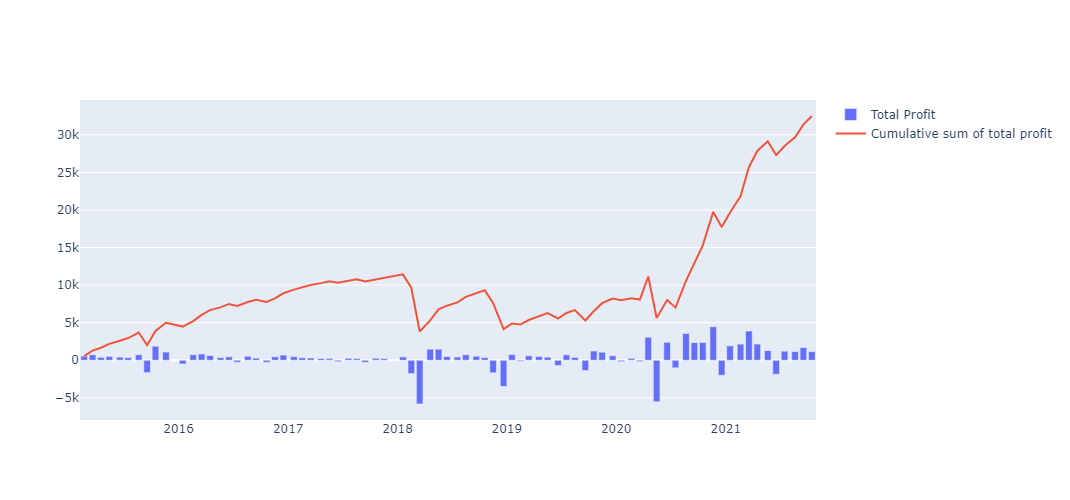

In [49]:
df1 = transaction.groupby(by = ['Exp_date'])['Total Profit/Loss'].sum().reset_index()
fig = make_subplots()

fig.add_trace(go.Bar(x=df1['Exp_date'], y=df1['Total Profit/Loss'], name = 'Total Profit'))
fig.add_trace(go.Line(x=df1['Exp_date'], y=df1['Total Profit/Loss'].cumsum(), name = 'Cumulative sum of total profit'))

fig.update_layout(height=500, width=1100)
fig.show()

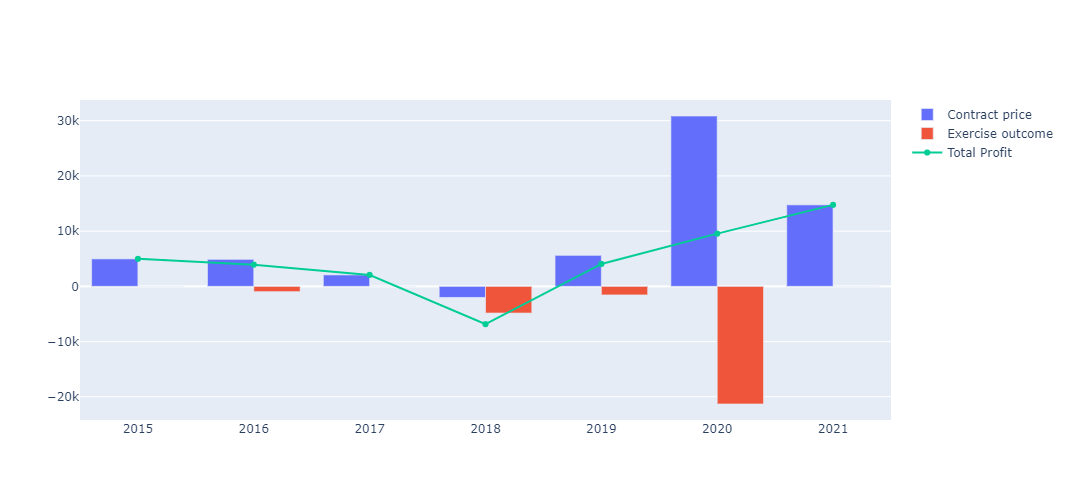

In [50]:
newdf = transaction.groupby(by = ['Year'])['Contract price','Exercise outcome', 'Total Profit/Loss' ].sum().reset_index()

fig = make_subplots()

fig.add_trace(go.Bar(x=newdf['Year'], y=newdf['Contract price'], name = 'Contract price'))
fig.add_trace(go.Bar(x=newdf['Year'], y=newdf['Exercise outcome'], name = 'Exercise outcome'))
fig.add_trace(go.Line(x=newdf['Year'], y=newdf['Total Profit/Loss'], name = 'Total Profit'))

fig.update_layout(height=500, width=1100)
fig.show()

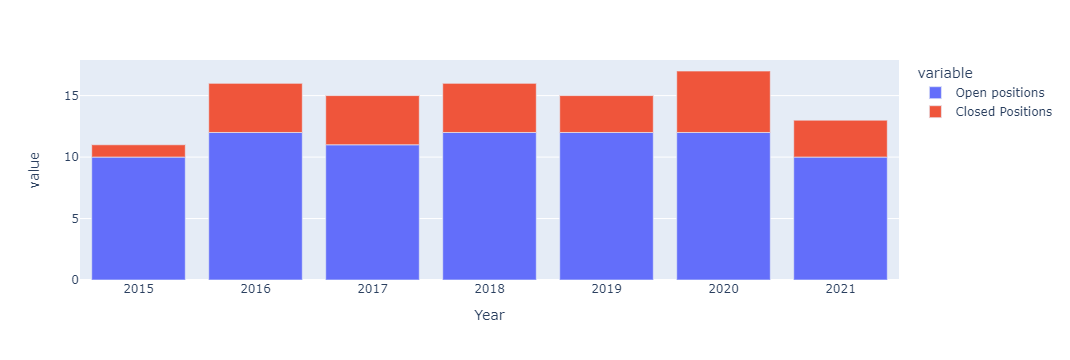

In [51]:
open_trans = transaction.loc[transaction['OTM size'].isnull() != True].groupby(by = ['Year'])['OTM size'].count()/4
closed_trans = transaction.loc[transaction['OTM size'].isnull() == True].groupby(by = ['Year'])['RIC'].count()/4
all_trams = pd.concat([open_trans,closed_trans], axis =1, keys = ['Open positions',  'Closed Positions']).reset_index()
fig = px.bar(all_trams, x = "Year", y = ["Open positions", "Closed Positions"])
fig.show()

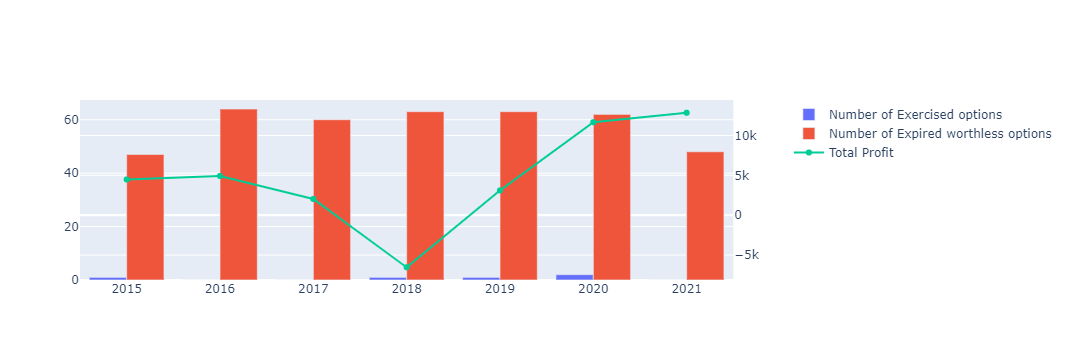

In [52]:
df2 = transaction.groupby(by = ['Outcome', 'Trans_Date', 'Exp_date', 'Option type', 'Position'])['Total Profit/Loss'].sum().reset_index()
df2.insert(loc = len(df2.columns), column = 'Year', value = [df2['Trans_Date'][i].year for i in range(len(df2))])

exer = df2.groupby('Year')['Outcome'].apply(lambda x: x[x == 'Exercised option'].count()).reset_index()
exp = df2.groupby('Year')['Outcome'].apply(lambda x: x[x == 'Expired worthless'].count()).reset_index()
prof = df2.groupby(by = ['Year'])['Total Profit/Loss'].sum().reset_index()

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Bar(x = exer['Year'], y = exer['Outcome'], name = "Number of Exercised options"), secondary_y = False)
fig.add_trace(go.Bar(x = exp['Year'], y = exp['Outcome'], name = "Number of Expired worthless options"), secondary_y = False)
fig.add_trace(go.Line(x = prof['Year'], y = prof['Total Profit/Loss'], name = "Total Profit"), secondary_y = True)
fig.show()

In [53]:
df3 = df2.groupby(by = ['Year', 'Outcome'])['Total Profit/Loss'].sum().reset_index()
exer = df3.loc[df3["Outcome"] == "Exercised option"]
exp = df3.loc[df3["Outcome"] == "Expired worthless"]

df4 = df2.groupby(by = ['Year', 'Option type'])['Total Profit/Loss'].sum().reset_index()
call = df4.loc[df4["Option type"] == "call"]
put = df4.loc[df4["Option type"] == "put"]

df5 = df2.groupby(by = ['Year', 'Position'])['Total Profit/Loss'].sum().reset_index()
short = df5.loc[df5["Position"] == "short"]
long = df5.loc[df5["Position"] == "long"]

df6 = df2.groupby(by = ['Year', 'Position', 'Option type'])['Total Profit/Loss'].sum().reset_index()
df6['Option'] = df6['Position'] + df6['Option type']
Long_call = df6.loc[df6["Option"] == "longcall"]
long_put = df6.loc[df6["Option"] == "longput"]
short_call = df6.loc[df6["Option"] == "shortcall"]
short_put = df6.loc[df6["Option"] == "shortput"]

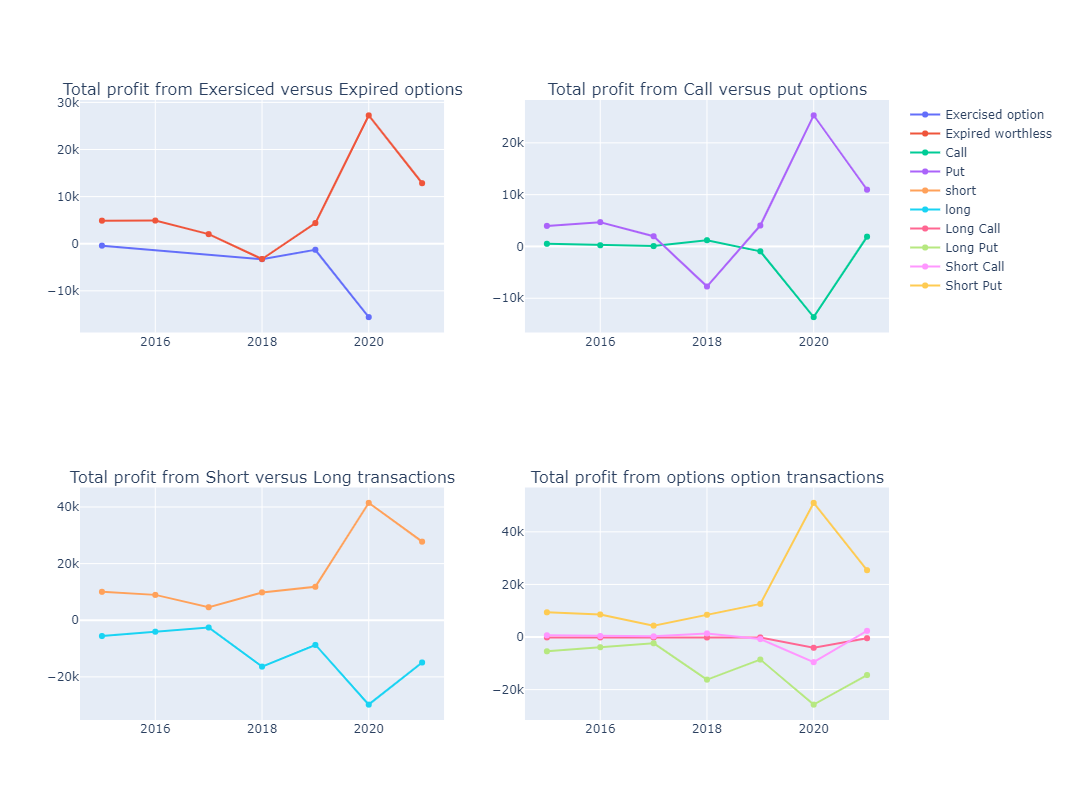

In [54]:
fig = make_subplots(rows=2, cols=2, subplot_titles = ['Total profit from Exersiced versus Expired options', 'Total profit from Call versus put options', 
                                                      'Total profit from Short versus Long transactions', 'Total profit from options option transactions'])

fig.add_trace(go.Line(x=exer["Year"], y=exer["Total Profit/Loss"], name = 'Exercised option'), row=1, col=1)
fig.add_trace(go.Line(x=exp["Year"], y=exp["Total Profit/Loss"], name = 'Expired worthless'), row=1, col=1)

fig.add_trace(go.Line(x=call["Year"], y=call["Total Profit/Loss"], name = 'Call'), row=1, col=2)
fig.add_trace(go.Line(x=put["Year"], y=put["Total Profit/Loss"], name = 'Put'), row=1,col=2)

fig.add_trace(go.Line(x=short["Year"], y=short["Total Profit/Loss"], name = 'short'), row=2, col=1)
fig.add_trace(go.Line(x=long["Year"], y=long["Total Profit/Loss"], name = 'long'), row=2,col=1)

fig.add_trace(go.Line(x=Long_call["Year"], y=Long_call["Total Profit/Loss"], name = 'Long Call'), row=2, col=2)
fig.add_trace(go.Line(x=long_put["Year"], y=long_put["Total Profit/Loss"], name = 'Long Put'),  row=2,col=2)
fig.add_trace(go.Line(x=short_call["Year"], y=short_call["Total Profit/Loss"], name = 'Short Call'), row=2, col=2)
fig.add_trace(go.Line(x=short_put["Year"], y=short_put["Total Profit/Loss"], name = 'Short Put'),  row=2,col=2)

fig.update_layout(height=800, width=1100)
fig.show()

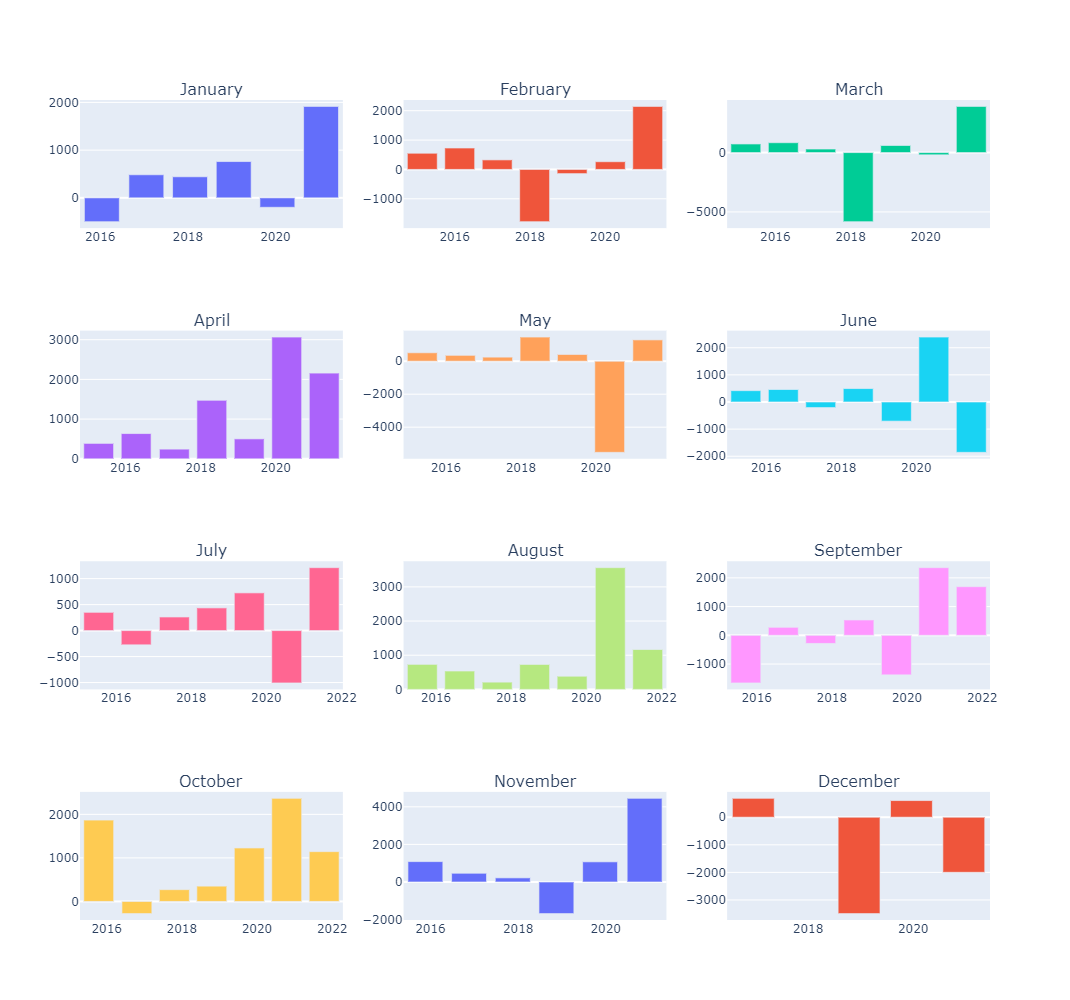

In [55]:
fig = make_subplots(rows=4, cols=3, subplot_titles = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'] )

n = 0
for i in range(1,5):
    for j in range(1, 4):
        n += 1
        x = df1['Exp_date'].loc[(df1['Exp_date'].dt.month==n)]
        y = df1['Total Profit/Loss'].loc[(df1['Exp_date'].dt.month==n)]
        fig.add_trace(
            go.Bar(x=x , y=y,showlegend=False),
            row=i, col=j
        )
fig.update_layout(height=1000, width=1100)

fig.show()

### Challanges:
>1. Not easily scaleable to other options - you may need to learn exchange rules and rebild the RIC reconstuction logic
>2. You need a lot of API requests so depending on the option and number of years to request you may hit the daily limit
>3. When you look at larger OTMs, market get's illiquid and you may end up having no option contract to buy for some months
>4. Option contract may be very different depending on a day you purchase, especially in larger OTMs